In [1]:
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import ocelot
from fel import SASE, random_beam, random_geometry, N_ELEMENTS

hidden_rng = np.random.RandomState(1111)

initializing ocelot...


In [2]:
class Optimiser(object):
    def __init__(self, x0):
        """
        Optimizer should accept initial configuration x0
        """
        pass

    def reset(self, ):
        """
        Auxilary method --- resets internal state of the optimiser.
        """
        raise NotImplementedError()
        
    def ask(self,):
        """
        Returns next configuration to probe.

        """
        raise NotImplementedError()
    
    def tell(self, x, f):
        """
        Callback method:
        `x` - configuration returned by `ask()` method (possibly clipped to satisfy bounds),
        `f` - value of the objective function in the point `x`.
        """
        raise NotImplementedError()

In [3]:
class Optimiser(object):
  def __init__(self, x0, scale=1e-2, seed=1122):
    self.x0 = x0
    self.rng = np.random.RandomState(seed=seed)

    self.x = x0
    self.f = None

    self.scale = scale

  def ask(self, ):
    return self.x + self.rng.normal(size=self.x.shape, scale=self.scale)

  def tell(self, x, f):
    if self.f is None:
      self.f = f
      self.x = x

    elif self.f < f:
      pass

    else:
      self.f = f
      self.x = x

  def reset(self, ):
    self.x = self.x0
    self.f = None

In [4]:
### constructing FEL
sase = SASE(random_beam(hidden_rng), random_geometry(hidden_rng))
epsilon = 1e-12

objective = lambda x: np.log(1e-3) - np.log(sase.rho_int(x) + epsilon)

bounds = np.stack([
    -2 * np.ones(sase.ndim()),
    2 * np.ones(sase.ndim())
], axis=1)

x0 = np.zeros(sase.ndim())

In [5]:
%%timeit
objective(np.random.uniform(-1, 1, size=sase.ndim()))

1 loop, best of 3: 1.63 s per loop


In [6]:
from fel import eval_optimization

In [7]:
xs, fs = eval_optimization(Optimiser, objective, x0=np.zeros(10), bounds=bounds, progress=tqdm)

In [8]:
def cummin(fs):
    result = np.zeros_like(fs)
    
    result[0] = fs[0]
    
    for i in range(1, fs.shape[0]):
        if result[i - 1] < fs[i]:
            result[i] = result[i - 1]
        else:
            result[i] = fs[i]
    
    return result

Text(0.5, 0, 'iteration')

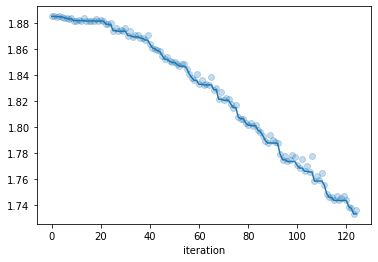

In [9]:
plt.plot(cummin(fs))
plt.scatter(np.arange(fs.shape[0]), fs, alpha=0.25)
plt.xlabel('iteration')